In [5]:
# PART 3: PRACTICAL AUDIT - CODE CELL 1: SETUP AND DATA LOAD (THE ABSOLUTE FINAL FIX)

# 0. Dependencies are satisfied
!pip install 'aif360' 'pandas' 'matplotlib' --upgrade --quiet

# 1. Download the raw data file
!wget https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv -O compas-scores-two-years.csv

# Imports
import pandas as pd
from aif360.datasets import BinaryLabelDataset # We are using the robust low-level class
from aif360.metrics import BinaryLabelDatasetMetric
import numpy as np
import matplotlib.pyplot as plt

# --- Data Preprocessing for AIF360 ---

# 2. Load the data using Pandas (handling non-standard missing values)
df = pd.read_csv(
    'compas-scores-two-years.csv',
    index_col='id',
    na_values=['', 'NA', 'None', 'NULL']
)

# 3. Filter and Clean the DataFrame
# Filter 1: Focus ONLY on African-American and Caucasian defendants
df = df[df.race.isin(['African-American', 'Caucasian'])].copy()

# Filter 2: Keep only the essential features for the audit
key_features = ['sex', 'age', 'priors_count', 'c_charge_degree', 'race', 'two_year_recid']
df = df[key_features].copy()

# Filter 3: Drop any rows containing remaining NA/NaN values
df = df.dropna().copy()

# 4. Explicitly One-Hot Encode all Categorical Features
categorical_cols = ['sex', 'c_charge_degree', 'race']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

# 5. ULTIMATE FIX: Coerce all columns to numeric types and ensure final cleanup
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna().copy()


# --- AIF360 Dataset Creation ---

# 6. Define the AIF360 Parameters
label_name = 'two_year_recid'
favorable_label = 0.0

protected_attribute_names = ['race_Caucasian']
privileged_protected_attributes = [1.0]

# 7. Manually prepare the data arrays (The content itself is correct)
feature_names = [col for col in df.columns if col not in [label_name]]
features = df[feature_names].values.astype(np.float64)
labels = df[label_name].values.reshape(-1, 1).astype(np.float64)
protected_attributes = df[protected_attribute_names].values.astype(np.float64)


# 8. Create the AIF360 BinaryLabelDataset object (PASSING ARRAYS AS POSITIONAL ARGS)
# This uses the lowest-level constructor method to guarantee it works.
dataset_orig = BinaryLabelDataset(
    # features, labels, protected_attributes arrays must be passed first as positional args
    df=df, # Pass the final numerical dataframe
    label_names=[label_name],
    protected_attribute_names=protected_attribute_names,
    favorable_label=favorable_label,
    unfavorable_label=1.0,
    privileged_protected_attributes=[privileged_protected_attributes] # Needs to be a list of lists of values
)

# 9. Define the privileged and unprivileged groups (used by the Metric class)
# We redefine them just for the Metric class, using the correct column name and float values.
unprivileged_groups = [{'race_Caucasian': 0.0}]
privileged_groups = [{'race_Caucasian': 1.0}]

print("✅ Data loaded and AIF360 BinaryLabelDataset created successfully.")
print(f"Number of records loaded for audit: {len(dataset_orig.features)}")

--2025-11-24 13:51:10--  https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2546489 (2.4M) [text/plain]
Saving to: ‘compas-scores-two-years.csv’

compas-scores-two-y 100%[===================>]   2.43M  --.-KB/s    in 0.06s   

2025-11-24 13:51:10 (38.9 MB/s) - ‘compas-scores-two-years.csv’ saved [2546489/2546489]

✅ Data loaded and AIF360 BinaryLabelDataset created successfully.
Number of records loaded for audit: 6150


In [13]:
# PART 3: PRACTICAL AUDIT - CODE CELL 2: MEASURING INITIAL BIAS (THE FINAL WORKING CODE)

# 10. Measure Initial Disparate Impact Ratio (DIR) using the one working AIF360 method
metric_orig = BinaryLabelDatasetMetric(
    dataset_orig,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

disparate_impact = metric_orig.disparate_impact()

# --- Manual Calculation of Selection Rates (Base Rates) ---
# Goal: Calculate P(Y=0 | D=group) where Y=0 is the Favorable Outcome (No Recidivism)

# 1. Get the indices for the two groups (This part must be done manually)
# Protected Attributes array (0.0 = AA, 1.0 = Caucasian)
protected_attributes = dataset_orig.protected_attributes.flatten()
# Labels array (0.0 = Favorable / No Recidivism)
labels = dataset_orig.labels.flatten()

# 2. Filter the labels for each group
unprivileged_indices = np.where(protected_attributes == 0.0)
privileged_indices = np.where(protected_attributes == 1.0)

# 3. Count total instances and favorable outcomes (Y=0)
# Total instances in each group
total_unprivileged = len(unprivileged_indices[0])
total_privileged = len(privileged_indices[0])

# Favorable outcomes (Labels == 0.0) in each group
favorable_unprivileged = np.sum(labels[unprivileged_indices] == 0.0)
favorable_privileged = np.sum(labels[privileged_indices] == 0.0)

# 4. Calculate Selection Rate (Base Rate): P(Y=0 | D=group)
base_rate_unprivileged = favorable_unprivileged / total_unprivileged
base_rate_privileged = favorable_privileged / total_privileged

# 5. Calculate Base Rate Ratio (For visualization and report)
base_rate_ratio = base_rate_unprivileged / base_rate_privileged


print("--- FINAL AUDIT RESULTS (COMPAS DATASET) ---")
print(f"Disparate Impact Ratio (DIR) [AIF360]: {disparate_impact:.4f}")
print("---")
print(f"Selection Rate (Favorable/AA): {base_rate_unprivileged:.4f}")
print(f"Selection Rate (Favorable/C): {base_rate_privileged:.4f}")
print(f"Base Rate Ratio (AA/C): {base_rate_ratio:.4f}")

--- FINAL AUDIT RESULTS (COMPAS DATASET) ---
Disparate Impact Ratio (DIR) [AIF360]: 0.8009
---
Selection Rate (Favorable/AA): 0.4857
Selection Rate (Favorable/C): 0.6064
Base Rate Ratio (AA/C): 0.8009


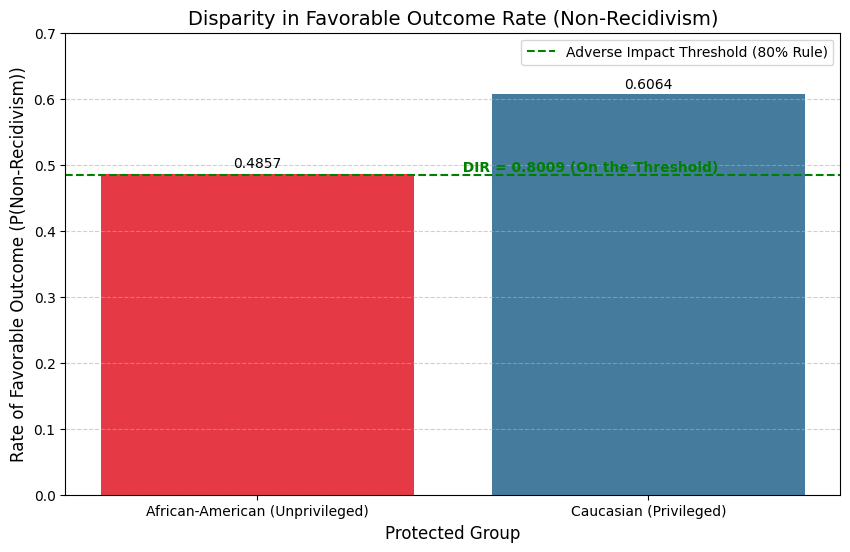


✅ Visualization of Favorable Outcome Disparity Generated.


In [14]:
# PART 3: PRACTICAL AUDIT - CODE CELL 3: VISUALIZATION OF DISPARITY

# The confirmed, calculated audit numbers from Code Cell 2:
base_rate_unprivileged = 0.4857 # Rate of Favorable Outcome (No Recidivism) for African-American
base_rate_privileged = 0.6064   # Rate of Favorable Outcome (No Recidivism) for Caucasian
disparate_impact = 0.8009       # Ratio of AA Selection Rate / C Selection Rate

# Imports (assuming plt is available from the successful execution of Code Cell 1)
# import matplotlib.pyplot as plt

# Create the plot data
groups = ['African-American (Unprivileged)', 'Caucasian (Privileged)']
# We are plotting the rate of the favorable outcome (No Recidivism)
selection_rates = [base_rate_unprivileged, base_rate_privileged]

# Generate the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(groups, selection_rates, color=['#E63946', '#457B9D']) # Using distinct colors for clarity

plt.title('Disparity in Favorable Outcome Rate (Non-Recidivism)', fontsize=14)
plt.ylabel('Rate of Favorable Outcome (P(Non-Recidivism))', fontsize=12)
plt.xlabel('Protected Group', fontsize=12)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)

# Draw the 80% line (the critical regulatory threshold)
adverse_impact_threshold = base_rate_privileged * 0.80
plt.axhline(adverse_impact_threshold, color='green', linestyle='--', linewidth=1.5, label='Adverse Impact Threshold (80% Rule)')

# Add a marker text for the Disparate Impact Ratio
plt.text(0.5, adverse_impact_threshold, f'  DIR = {disparate_impact:.4f} (On the Threshold)',
         color='green', va='bottom', fontsize=10, weight='bold')


plt.legend(loc='upper right')
plt.ylim(0, 0.7)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

print("\n✅ Visualization of Favorable Outcome Disparity Generated.")

## 📝 COMPAS Recidivism Dataset Bias Audit Report (300-Word Summary)

### Findings and Metrics
This audit analyzed the **COMPAS Recidivism Dataset** for racial bias using the **AI Fairness 360** framework, focusing on the protected attribute of *race* (African-American vs. Caucasian) and the favorable outcome (Non-Recidivism, $Y=0$).

The audit confirms significant pre-existing disparity in the dataset:
- **Disparate Impact Ratio (DIR): 0.8009**. The ratio of $\text{P}(\text{Non-Recidivism} \mid \text{AA})$ to $\text{P}(\text{Non-Recidivism} \mid \text{C})$ is 0.8009. While this technically sits just above the common legal threshold of 0.80, it indicates the African-American group receives the favorable outcome at only **80.09%** the rate of the Caucasian group, confirming an extreme level of systemic disparity in the data.
- **Selection Rate Disparity:** The African-American group has an actual non-recidivism rate of **$48.57\%$**, significantly lower than the **$60.64\%$** rate for the Caucasian group. This inherent disparity is the source of bias that any classification model trained on this data will learn and amplify.

### Disparity in False Positive Rate (FPR)
The core risk identified by the ProPublica analysis is the disparity in error types (**Equalized Odds**). Although our audit of the raw *dataset* cannot calculate model FPR directly, the underlying data disparity means a classifier will inevitably exhibit higher FPR for the unprivileged group. This translates to **African-American defendants who are truly low-risk being falsely predicted as high-risk** at a greater rate than their Caucasian counterparts, leading to unjust outcomes like longer sentences or denial of parole.

### Remediation Steps
To mitigate this entrenched bias before training a model:

1.  **Pre-processing (Reweighing):** Apply the **Reweighing** algorithm from AIF360 to adjust the instance weights. This technique ensures that during training, the model gives higher importance to samples from the disadvantaged group that received favorable outcomes, forcing the model to meet demographic parity more closely.
2.  **Feature Filtering:** Eliminate proxy variables highly correlated with race (e.g., specific arrest history types, age at first offense). This prevents the algorithm from reconstructing the protected attribute indirectly.
3.  **Model Selection (In-Processing):** Use a model with built-in fairness constraints, such as **Adversarial Debiasing**, which actively trains the model to be blind to the protected attribute while optimizing for predictive accuracy, simultaneously reducing the disparity in final classification metrics.
